In [388]:
import math
import glob
import numpy as np
import pandas as pd
from functools import reduce
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split

In [389]:
all_files = glob.glob('C:/Users/lzoeckler/Desktop/FOR_ML/binned/*.csv')
big_df = []
for file in all_files:
    df = pd.read_csv(file)
    big_df.append(df)
big_df = pd.concat(big_df, sort=True)
big_df = big_df.loc[big_df['study_id'] == '16-SMRU-01']
big_df.head()

,HRP2_deletion,PCR_pos,age_yrs,coinfection,country,febrile,infection_category,lat,long,microscopy_pos,...,quansys_LDH_Pf_result,quansys_LDH_Pv_bin,quansys_LDH_Pv_pg_ml,quansys_LDH_Pv_result,quansys_type,sample_id,sample_type,study_id,survey,timepoint_days
0,NaN,0.0,NaN,0.0,Myanmar,0.0,chronic,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0,4plex,1 110501023 (),WB,16-SMRU-01,cross sectional,NaN
1,NaN,0.0,NaN,0.0,Myanmar,0.0,chronic,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0,4plex,1 1421001 (),WB,16-SMRU-01,cross sectional,NaN
2,NaN,0.0,NaN,0.0,Myanmar,0.0,chronic,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0,4plex,1 1421035 (),WB,16-SMRU-01,cross sectional,NaN
3,NaN,0.0,NaN,0.0,Myanmar,0.0,chronic,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0,4plex,1 151019 (),WB,16-SMRU-01,cross sectional,NaN
4,NaN,0.0,NaN,0.0,Myanmar,0.0,chronic,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0,4plex,1 1771028 (),WB,16-SMRU-01,cross sectional,NaN


In [390]:
len(big_df)

1847

In [429]:
def clean_strings(val):
    if isinstance(val, str):
        if '<' in val:
            return np.log10(1)
        elif '>' in val:
            clean = val.replace('> ', '')
            return np.log10(float(clean) + 1)
        else:
            try:
                return np.log10(float(val) + 1)
            except ValueError:
                return np.null
    elif isinstance(val, float) or isinstance(val, int):
        return np.log10(val + 1)
    else:
        raise

In [430]:
test_df = big_df.copy(deep=True)
test_df = test_df.loc[~test_df['quansys_CRP_ng_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_LDH_Pan_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df['target'] = test_df['PCR_pos']
test_df = test_df[['quansys_HRP2_pg_ml', 'quansys_LDH_Pan_pg_ml', 'target']]
test_df['quansys_HRP2_pg_ml'] = test_df['quansys_HRP2_pg_ml'].apply(clean_strings)
test_df['quansys_LDH_Pan_pg_ml'] = test_df['quansys_LDH_Pan_pg_ml'].apply(clean_strings)
# test_df = pd.read_csv('C:/Users/lzoeckler/Desktop/Myanmar_data_prepped.csv')
# test_df = test_df[['log10_HRP2', 'log10_panLDH', 'qPCR']]
# test_df.rename(columns={'log10_HRP2': 'quansys_HRP2_pg_ml',
#                         'log10_panLDH': 'quansys_LDH_Pan_pg_ml',
#                         'qPCR': 'target'}, inplace=True)
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,target
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [443]:
known_df = test_df.loc[~test_df['target'].isnull()]

In [444]:
len(known_df)

1808

In [445]:
# hrp2_sens = []
# hrp2_spec = []
# aucs = []
# for i in range(1000):
#     x_hrp2_train, x_hrp2_test, y_hrp2_train, y_hrp2_test = train_test_split(hrp2_df['quansys_HRP2_pg_ml'],
#                                                     hrp2_df['target'],
#                                                     train_size=0.8,
#                                                     test_size=0.2)
    
hrp2_data = known_df['quansys_HRP2_pg_ml'].values
test_vals = known_df['target']
hrp2_binary_data = test_vals.values.reshape(-1, 1)
hrp2_end_df = pd.DataFrame()

hrp2 = linear_model.LogisticRegression()
hrp2.fit(hrp2_data.reshape(-1, 1), hrp2_binary_data)
probabilities = hrp2.predict_proba(hrp2_data.reshape(-1,1))
non_prob = hrp2.predict(hrp2_data.reshape(-1,1))
hrp2_end_df['probability_of_1_hrp2'] = probabilities[:, 1]
hrp2_end_df['predicted_val_hrp2'] = non_prob
hrp2_end_df['target'] = test_vals.values

target = hrp2_end_df['target']
results = hrp2_end_df['predicted_val_hrp2']
prob_results = hrp2_end_df['probability_of_1_hrp2']
# cm = confusion_matrix(target, results)
# hrp2_sens.append(cm[0,0] / (cm[0,0] + cm[0,1]))
# hrp2_spec.append(cm[1,1] / (cm[1,0] + cm[1,1]))

fpr, tpr, threshold = roc_curve(target, prob_results)
# aucs.append(auc(fpr, tpr))
area = auc(fpr, tpr)

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [446]:
fpr2 = 1 - fpr
combo = fpr2 + tpr
max_loc = np.where(combo == max(combo))[0][0]
sens = tpr[max_loc]
spec = fpr2[max_loc]

In [447]:
sens

0.3952755905511811

In [448]:
spec

0.9616368286445013

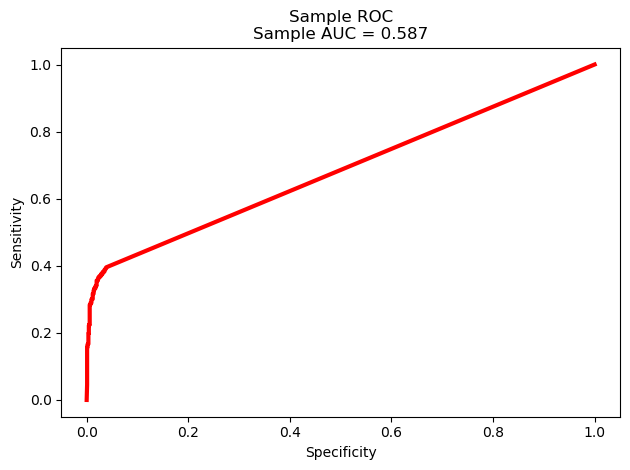

In [437]:
plt.plot(fpr, tpr, color='red', linewidth=3)
plt.title('Sample ROC\nSample AUC = {}'.format(round(roc_auc, 3)))
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.tight_layout()
plt.show()
plt.close()

In [438]:
# ldh_sens = []
# ldh_spec = []
# for i in range(1000):
#     x_ldh_train, x_ldh_test, y_ldh_train, y_ldh_test = train_test_split(ldh_df['quansys_LDH_Pan_pg_ml'],
#                                                     ldh_df['target'],
#                                                     train_size=0.8,
#                                                     test_size=0.2)
    
ldh_data = ldh_df['quansys_LDH_Pan_pg_ml'].values
test_vals = ldh_df['target']
ldh_binary_data = test_vals.values.reshape(-1, 1)
ldh_end_df = pd.DataFrame()

ldh = linear_model.LogisticRegression()
ldh.fit(ldh_data.reshape(-1, 1), ldh_binary_data)
probabilities = ldh.predict_proba(ldh_data.reshape(-1,1))
non_prob = ldh.predict(ldh_data.reshape(-1,1))
ldh_end_df['probability_of_1_ldh'] = probabilities[:, 1]
ldh_end_df['predicted_val_ldh'] = non_prob
ldh_end_df['target'] = test_vals.values

target = ldh_end_df['target']
results = ldh_end_df['predicted_val_ldh']
prob_results = ldh_end_df['probability_of_1_ldh']
# cm = confusion_matrix(target, results)
# ldh_sens.append(cm[0,0] / (cm[0,0] + cm[0,1]))
# ldh_spec.append(cm[1,1] / (cm[1,0] + cm[1,1]))

fpr, tpr, threshold = roc_curve(target, prob_results)
area = auc(fpr, tpr)

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [439]:
fpr2 = 1 - fpr
combo = fpr2 + tpr
max_loc = np.where(combo == max(combo))[0][0]
sens = tpr[max_loc]
spec = fpr2[max_loc]

In [440]:
sens

0.8771653543307086

In [441]:
spec

0.947996589940324

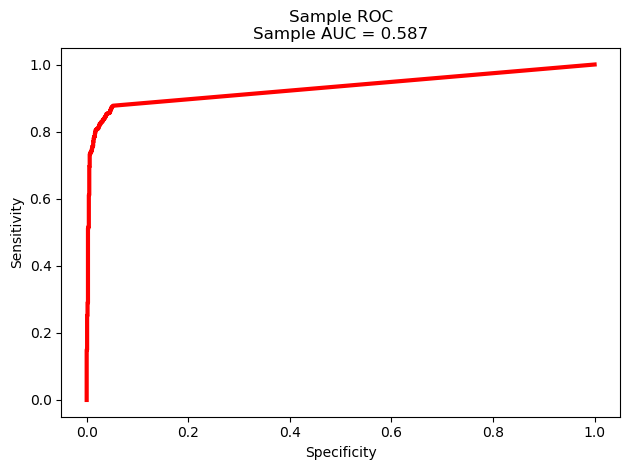

In [442]:
plt.plot(fpr, tpr, color='red', linewidth=3)
plt.title('Sample ROC\nSample AUC = {}'.format(round(roc_auc, 3)))
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.tight_layout()
plt.show()
plt.close()

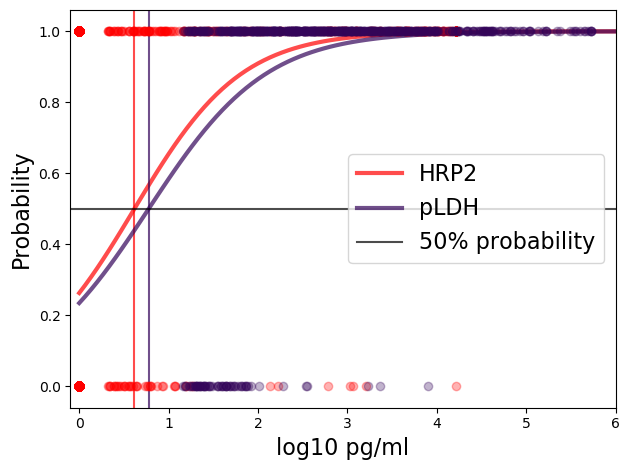

In [451]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/myan_log_reg_plot.pdf')
f = plt.figure()
# HRP2
plt.scatter(hrp2_data, hrp2_binary_data, color='r', zorder=20, alpha=0.3)
X_test = np.linspace(0, 200, 3000)
loss = expit(X_test * hrp2.coef_ + hrp2.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3, alpha=0.7,
         label='HRP2')
hrp2_prob = ((0 - hrp2.intercept_) / hrp2.coef_).item()
plt.axvline(hrp2_prob, color='r', alpha=0.7)
# LDH
plt.scatter(ldh_data, ldh_binary_data, color='#34055A', zorder=20, alpha=0.3)
X_test = np.linspace(0, 200, 3000)
loss = expit(X_test * ldh.coef_ + ldh.intercept_).ravel()
plt.plot(X_test, loss, color='#34055A', linewidth=3, alpha=0.7,
         label='pLDH')
ldh_prob = ((0 - ldh.intercept_) / ldh.coef_).item()
plt.axvline(ldh_prob, color='#34055A', alpha=0.7)
# Generic
plt.axhline(0.5, color='k', alpha=0.7, label='50% probability')
plt.ylabel('Probability', fontsize=16)
plt.xlabel('log10 pg/ml', fontsize=16)
plt.xlim(-.1, 6)
# plt.xticks([0, 100, 200, 300, 500, 750, 1000])
plt.legend(fontsize=16)
# plt.title('', fontsize=16)
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [452]:
# This bit is super manual right now, could definitely be better...
tests = ('HRP2 Logistic Regression', 'pLDH Logistic Regression',
         'Machine Learning', 'Field RDT', 'Field u-RDT', 'Lab RDT',
         'Lab u-RDT')
y_pos = np.arange(len(tests))

sensitivity = (40, 88, 97, 17, 37, 27, 54)
specificity = (96, 95, 87, 99, 99, 99, 99)

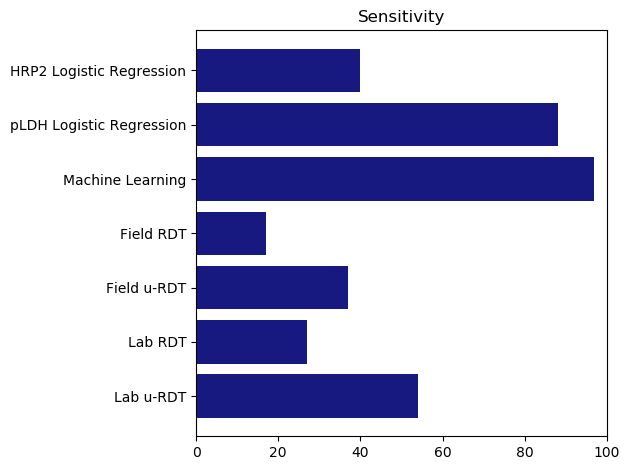

In [453]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/sens.pdf')
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, sensitivity, align='center', color='#171980')
ax.set_yticks(y_pos)
ax.set_yticklabels(tests)
ax.invert_yaxis()
# ax.set_xlabel('Sensitivity')
ax.set_xlim(0, 100)
ax.set_title('Sensitivity')
plt.tight_layout()
plt.show()
pp.savefig(fig)
plt.close()
pp.close()

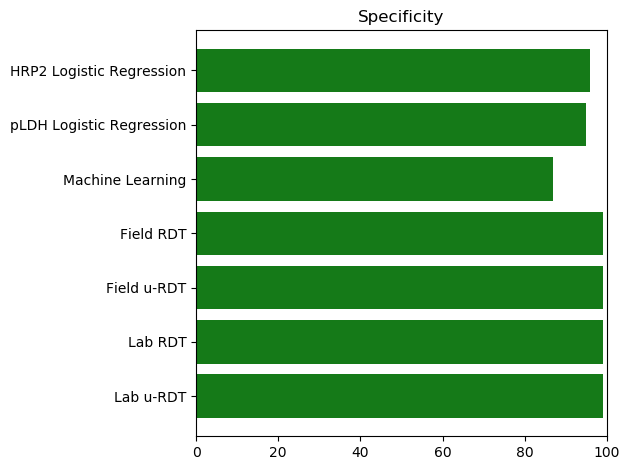

In [454]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/spec.pdf')
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, specificity, align='center', color='#157a18')
ax.set_yticks(y_pos)
ax.set_yticklabels(tests)
ax.invert_yaxis()
# ax.set_xlabel('Sensitivity')
ax.set_xlim(0, 100)
ax.set_title('Specificity')
plt.tight_layout()
plt.show()
pp.savefig(fig)
plt.close()
pp.close()

In [342]:
leo_v = pd.read_csv('C:/Users/lzoeckler/Desktop/myan_compare/leo.csv')
print(leo_v['qPCR'].dtype)
leo_v.head()

float64


,sample_id,febrile,qPCR,HRP2_pg_ml,LDH_Pan_pg_ml,LDH_Pv_pg_ml,CRP_ng_ml
0,1 110501023 (),0,0.0,< 1.07,< 14.41,< 2.33,324.42422
1,1 1421001 (),0,0.0,< 1.07,< 14.41,< 2.33,384.08657
2,1 1421035 (),0,0.0,< 1.07,< 14.41,< 2.33,43.83038
3,1 151019 (),0,0.0,< 1.07,< 14.41,< 2.33,1971.18307
4,1 1771028 (),0,0.0,< 1.07,< 14.41,< 2.33,1020.97418


In [343]:
han_v = pd.read_csv('C:/Users/lzoeckler/Desktop/myan_compare/hannah.csv')
han_v['qPCR'] = han_v['qPCR'].astype('float64')
han_v.head()

,sample_id,febrile,qPCR,HRP2_pg_ml,LDH_Pan_pg_ml,LDH_Pv_pg_ml,CRP_ng_ml
0,1 110501023 (),0,0.0,< 1.07,< 14.41,< 2.33,324.42422
1,1 1421001 (),0,0.0,< 1.07,< 14.41,< 2.33,384.08657
2,1 1421035 (),0,0.0,< 1.07,< 14.41,< 2.33,43.83038
3,1 151019 (),0,0.0,< 1.07,< 14.41,< 2.33,1971.18307
4,1 1771028 (),0,0.0,< 1.07,< 14.41,< 2.33,1020.97418


In [344]:
def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('First', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

In [345]:
df_all = pd.concat([leo_v.set_index('sample_id'), han_v.set_index('sample_id')],
                  axis='columns', keys=['First', 'Second'])
df_all = df_all.swaplevel(axis='columns')[leo_v.columns[1:]]
df_all.style.apply(highlight_diff, axis=None)